## Problem 1: Visualise data in a static map (10 points)


Create a *static* **thematic map** using the skills you learnt during lesson 5. The map should <br>
contain more than one layer (from at least two different data sets). Pay attention to classification <br>
and visualisation (appropriate colour scheme choice, etc.). Write your code in this notebook, and <br>
store the resulting maps in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder.

### Topic of the map

- Use any of the data sets we have used during the course (travel time data, population grid), or <br>
  any other data set of your interest (for example, [open data sets from Statistics Finland](https://www.stat.fi/org/avoindata/index_en.html), <br>
  or the open geo-data from [the Helsinki Region Infoshare](https://hri.fi/en)). If you download <br>
  data sets, add, commit, and push them to the `DATA_DIRECTORY`. Be sure to include an attribution <br>
  to each data set in your output map!
- Feel free to start from and adapt examples from the course material! You can take one step further <br>
  and add additional analysis to, e.g., the shopping centre dominance or the population within vincinity <br>
  of certain addresses)

### Criteria

- The map has more than one data layer (for instance, the results of an analysis, and the road network <br>
  to illustrate a complex spatial pattern). If (and only if) you think it adds additional value, feel <br>
  free to add a base map (but a base map does not count as an own layer)
- The map portrays the output of an analysis or a classification that adds value beyond just displaying <br>
  the raw data
- The map follows good cartographic practices (appropriate map extent and zoom level, colour scheme, <br>
  legend and data sources, etc.)

### Output

- Save the map(s) in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder, remember to add, commit, <br>
  and push them to the GitHub repository
- Remember to also add, commit, and push input data sets and code

---

In [57]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "docs"

In [58]:
# ADD YOUR OWN CODE HERE
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily
import folium
import requests
import zipfile
from shapely.geometry import box

In [83]:
# Downloads and extracting data from .zip files
vuln_map_uri = "https://www.hel.fi/hel2/Tietokeskus/data/helsinki/kaupunginkanslia/Urban_Heat_Vulnerability_Map_of_Helsinki/Geographic_JavaScript_Object_Notation_GeoJSON.zip"
vuln_map_zip_file_path = DATA_DIRECTORY / "Geographic_JavaScript_Object_Notation_GeoJSON.zip"

with open(vuln_map_zip_file_path, "wb") as file:
    response = requests.get(vuln_map_uri)
    file.write(response.content)

with zipfile.ZipFile(vuln_map_zip_file_path, "r") as archive:
    archive.extractall(DATA_DIRECTORY)

heat_stress_zip_file_path = DATA_DIRECTORY / "T2M_JJA_shp.zip"
heat_stress_uri = "https://avoidatastr.blob.core.windows.net/avoindata/AvoinData/3_Ilmanlaatu_ja_ilmasto/Ilmasto/URCLIM_kaupunkisaamalli/T2M_JJA_shp.zip"

with open(heat_stress_zip_file_path, "wb") as file:
    response = requests.get(heat_stress_uri)
    file.write(response.content)

with zipfile.ZipFile(heat_stress_zip_file_path, "r") as archive:
    archive.extractall(DATA_DIRECTORY / "temperature")

temp_path = "data/temperature/H327_T2M_JJA.shp"

WFS_URL = (
    "https://kartta.hel.fi/ws/geoserver/avoindata/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&srsName=EPSG:3879"
    "&typeName={layer:s}"
).format(layer="avoindata:Seutukartta_liikenne_metro_rata")

In [90]:
vuln_map_df = gpd.read_file(DATA_DIRECTORY / "Geographic_JavaScript_Object_Notation_GeoJSON/Urban Heat Vulnerability Dataset for Helsinki, Finland.geojson")
temp_df = gpd.read_file(temp_path)
metro_df = gpd.read_file(WFS_URL).set_crs(vuln_map_df.crs)

# temp_df = temp_df.to_crs(vuln_map_df.crs) # in case not...
assert metro_df.crs == vuln_map_df.crs == temp_df.crs

<Axes: >

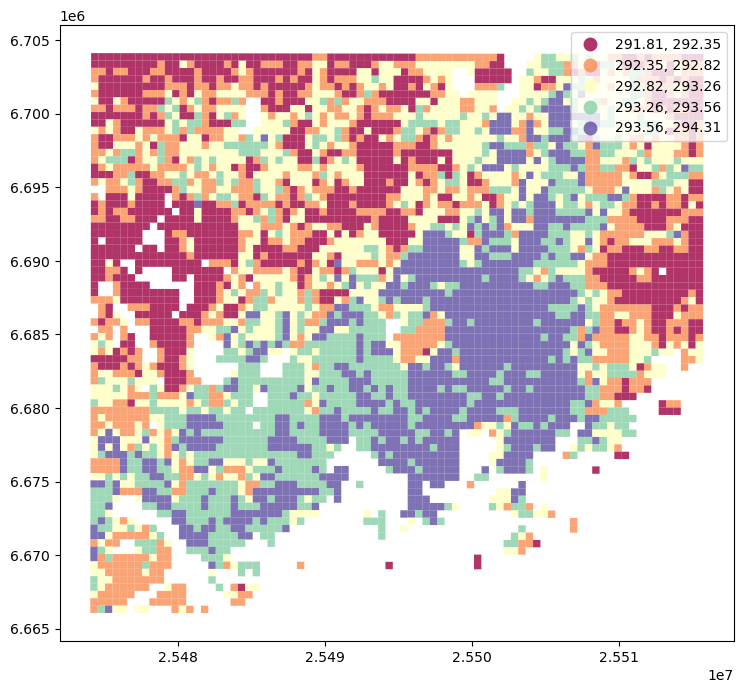

In [98]:
temp_df.plot(
    figsize=(12, 8),
    column="value",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,
legend=True
)

In [72]:
# In case bounding of a df is necessary
helsinki_bounds = vuln_map_df.bounds
minx, miny, maxx, maxy = (helsinki_bounds.minx.min(), 
                 helsinki_bounds.miny.min(),
                 helsinki_bounds.maxx.max(),
                 helsinki_bounds.maxy.max())
bbox = box(minx, miny, maxx, maxy)
metro_df = metro_df[metro_df.geometry.within(bbox)]

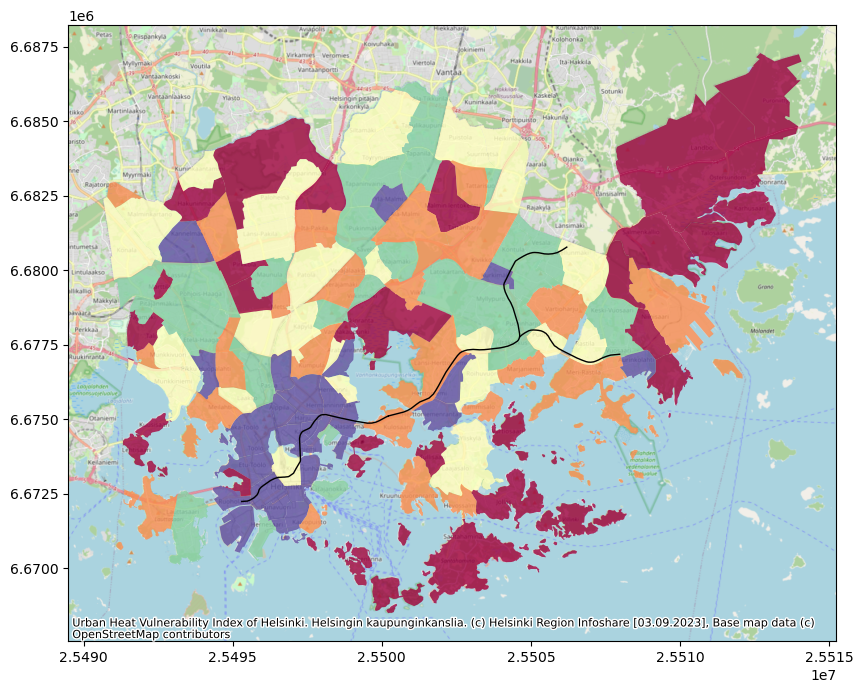

In [76]:
ax = vuln_map_df.plot(
    figsize=(12, 8),
    column="Avg-UHVI: Average Urban Heat Vulnerability Index (From Raster)",
    scheme="quantiles",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8
)

metro_df.plot(
    ax=ax,
    color="black",
    linewidth=1,
    alpha=1,

)

# Add a basemap
contextily.add_basemap(
    ax=ax,
    source=contextily.providers.OpenStreetMap.Mapnik,
    crs=vuln_map_df.crs,
    attribution=(
        "Urban Heat Vulnerability Index of Helsinki. Helsingin kaupunginkanslia. (c) Helsinki Region Infoshare [03.09.2023], " 
        "Base map data (c) OpenStreetMap contributors"
    )
)